In [1]:
from nlu_engine import EntityExtractor, crf
from nlu_engine import Analytics
from nlu_engine import RenderJSON
from nlu_engine import DataUtils
from nlu_engine import MacroEntityRefinement
from nlu_engine import MacroDataRefinement

from nlu_engine import NLUEngine
import nltk
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
#TODO: redo intro to be specific for general reports

# Macro NLU Entity General Reports

It's a bit like the TV show [Serverance](https://www.imdb.com/title/tt11280740/) .

![Helly R and Mark S](https://media.npr.org/assets/img/2022/02/15/atv_severance_photo_010103-5f8033cc2b219ba64fe265ce893eae4c90e83896-s1100-c50.jpg "Helly R and Mark G")

*Helly R*: `My job is to scroll through the spreadsheet and look for the numbers that feel scary?`

*Mark S*: `I told you, you’ll understand when you see it, so just be patient.`

![MDR](https://www.imore.com/sites/imore.com/files/styles/large/public/field/image/2022/03/refinement-software-severance-apple-tv.jpg "serverance micro data refinement")

*Helly R*: `That was scary. The numbers were scary.`

Hopefully the intents and entities that are wrong aren't scary, just a bit frustrating. Let's see if we can find the right ones.

NOTE: We will use Logistic Regression with TFIDF features to train our intent models and CRFs for entity exraction. Why? Well, they are very fast and both methods aren't state-of-the-art. This is good, because it is easier to find problems we will need to refine in the dataset than if we were to use a proper NLU engine like Snips or something SOTA like BERT. It is very important to note that some of the the problems we will pick up on, might not be an actual issue, but might be due to the limitations of the models. Refining the real problems and ignoring the limitations of the models is a good way to improve the models. Then when the dataset is ready, we can use some more advanced NLU engine and get the best performance possible.

* Macro NLU Data Refinement: Intent
* Macro NLU Data Refinement: Entity


Load the dataset

In [2]:
try:
    nlu_data_df = pd.read_csv(
        'data/refined/nlu_data_refined_df.csv', sep=',', index_col=0)
    print('Successfully loaded nlu_data_refined_df.csv')
except:
    data = 'data/NLU-Data-Home-Domain-Annotated-All-Cleaned.csv'
    nlu_data_df = DataUtils.load_data(
    data
)

Successfully loaded nlu_data_refined_df.csv


Make sure `nlu_data_df['answer_normalised']` is taken from `nlu_data_df['answer_annotation']`

In [3]:
nlu_data_df = DataUtils.convert_annotated_utterances_to_normalised_utterances(
    nlu_data_df)


We should remove the unwanted entries for the next few steps.

In [4]:
removed_nlu_data_refined_df = nlu_data_df[nlu_data_df['remove'] != True]

# Entity extraction report

The entity extraction could be greatly improved by improving the features it uses. It would be great if someone would take a look at this. Perhaps the CRF features similar to what Snips uses would be better such as Brown clustering (probably).

It is important to have the NLTK tokenizer to be able to extract entities.

In [ ]:
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
        nltk.download('punkt')
        nltk.download('averaged_perceptron_tagger')

We can create a new entity report or load a previous one.

Load a previous report

In [5]:
entity_report_df = pd.read_csv('data/reports/entity_report.csv')

Create a new entity report

Due to this error featured in [this git issue](https://github.com/TeamHG-Memex/sklearn-crfsuite/issues/60) we have to use an older version of scikit learn (sklearn<0.24), otherwise the latest version would work. Hopefully this gets fixed one day..

In [ ]:
entity_report_df = NLUEngine.evaluate_entity_classifier(
    data_df=removed_nlu_data_refined_df, cv=4)

In [ ]:
entity_report_df

Let's have a look at the report plotted for us

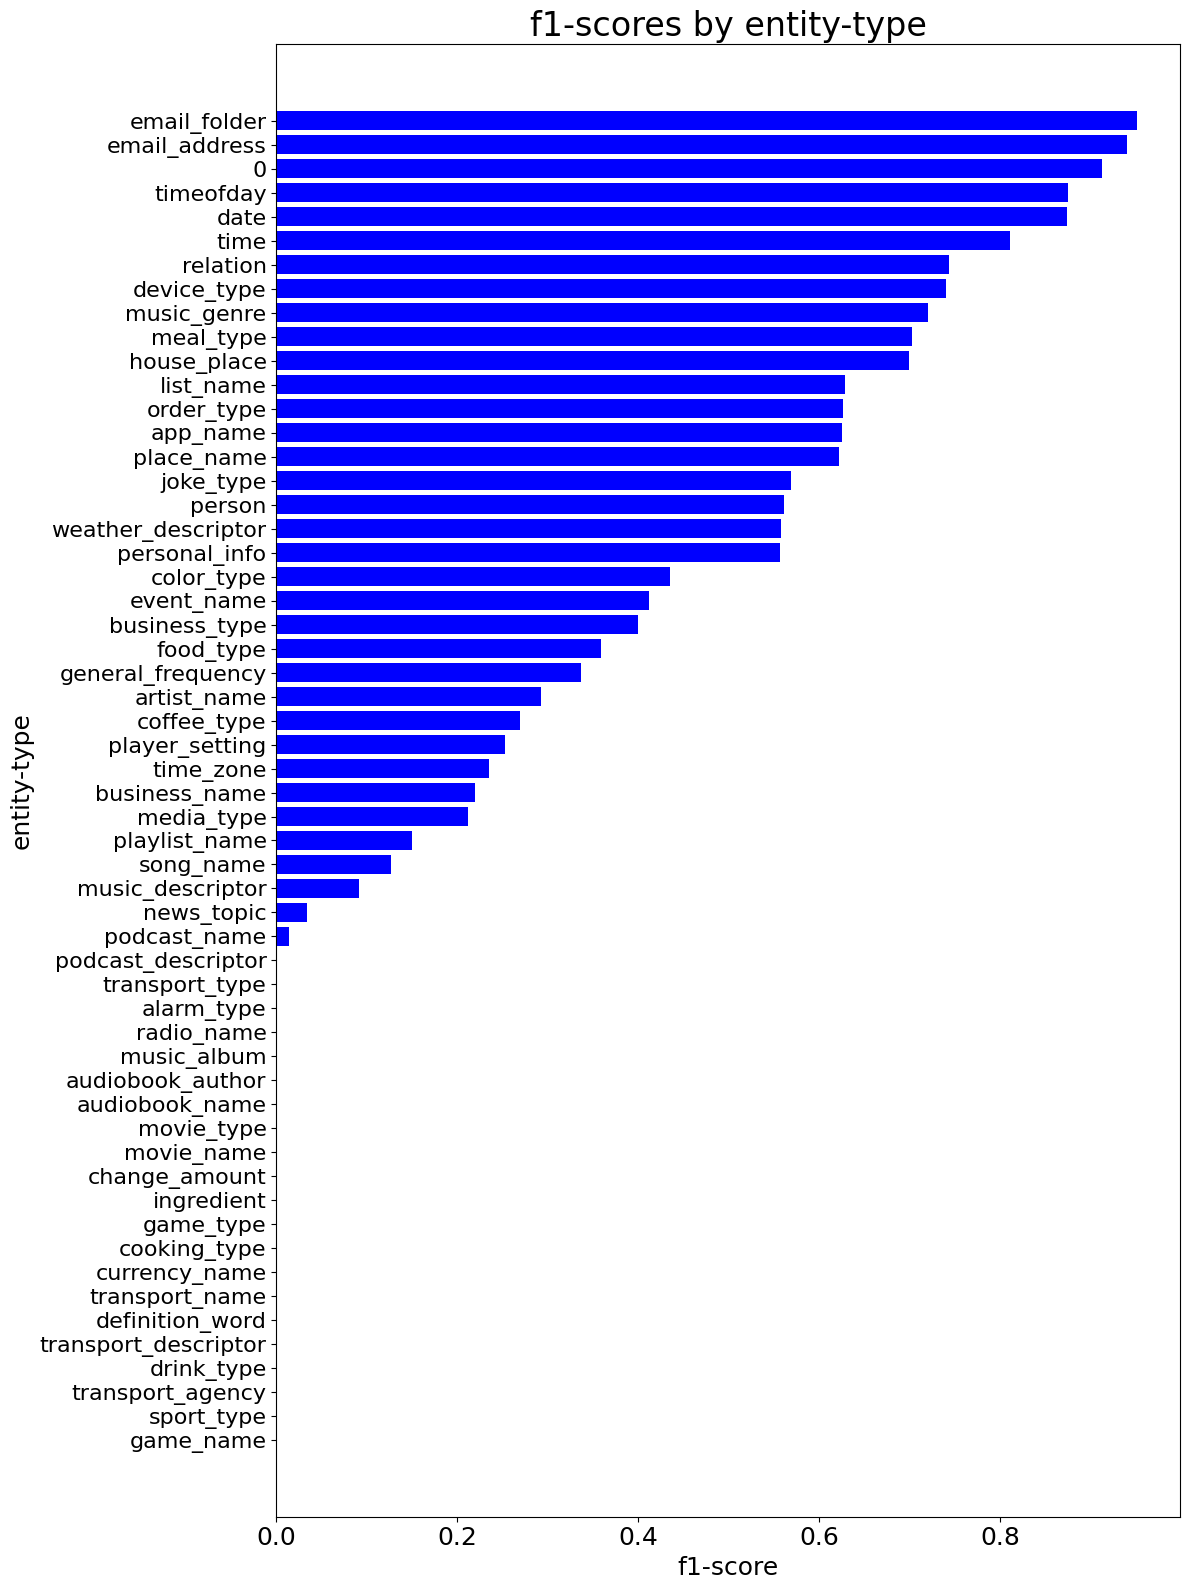

In [6]:
Analytics.plot_report(entity_report_df)

We can save the current report if we wish.

In [ ]:
entity_report_df.to_csv(
    'data/reports/entity_report.csv',
    index=False)

We will need to extract out the entity types from the dataset. We need this to calculate the precentage of entities, to filter out any domains that have too few entities for benchmarking by domain instead of all domains together.

In [7]:
nlu_data_df['entities'] = nlu_data_df['answer_annotation'].apply(
    EntityExtractor.extract_entities)

nlu_data_df['entity_types'] = nlu_data_df['entities'].apply(
    EntityExtractor.extract_entity_types)

import numpy as np
nlu_data_df['entity_types'] = nlu_data_df['entity_types'].apply(lambda y: np.nan if len(y)==0 else y)
nlu_data_df['entities'] = nlu_data_df['entities'].apply(lambda y: np.nan if len(y)==0 else y)

removed_nlu_data_df = nlu_data_df[nlu_data_df['remove'] != True]

We will have a look at the domain entity reports. We can load a previous report or create a new one.

Load a previous report

In [8]:
domain_entity_reports_df = pd.read_csv('data/reports/domain_entity_reports.csv')

Create a new report

In [ ]:
domain_entity_reports_df = NLUEngine.get_entity_reports_for_domains(removed_nlu_data_refined_df)

domain_entity_reports_df = domain_entity_reports_df[domain_entity_reports_df['entity-type'].str.contains(
    'weighted avg')].sort_values(by='f1-score', ascending=True)

In [9]:
domain_entity_reports_df

,entity-type,precision,recall,f1-score,support,domain
0,weighted avg,0.644421,0.685911,0.659549,11051.0,play
1,weighted avg,0.684923,0.782016,0.725743,367.0,music
2,weighted avg,0.838414,0.846966,0.839535,2274.0,takeaway
3,weighted avg,0.844779,0.866175,0.852882,3527.0,recommendation
4,weighted avg,0.884246,0.888836,0.885063,18819.0,calendar
5,weighted avg,0.890012,0.892921,0.888886,4492.0,news
6,weighted avg,0.881286,0.900264,0.889026,2647.0,lists
7,weighted avg,0.878675,0.905823,0.890492,1975.0,cooking
8,weighted avg,0.909339,0.915642,0.912069,6508.0,weather
9,weighted avg,0.915545,0.921031,0.916768,4850.0,iot


Plot the report

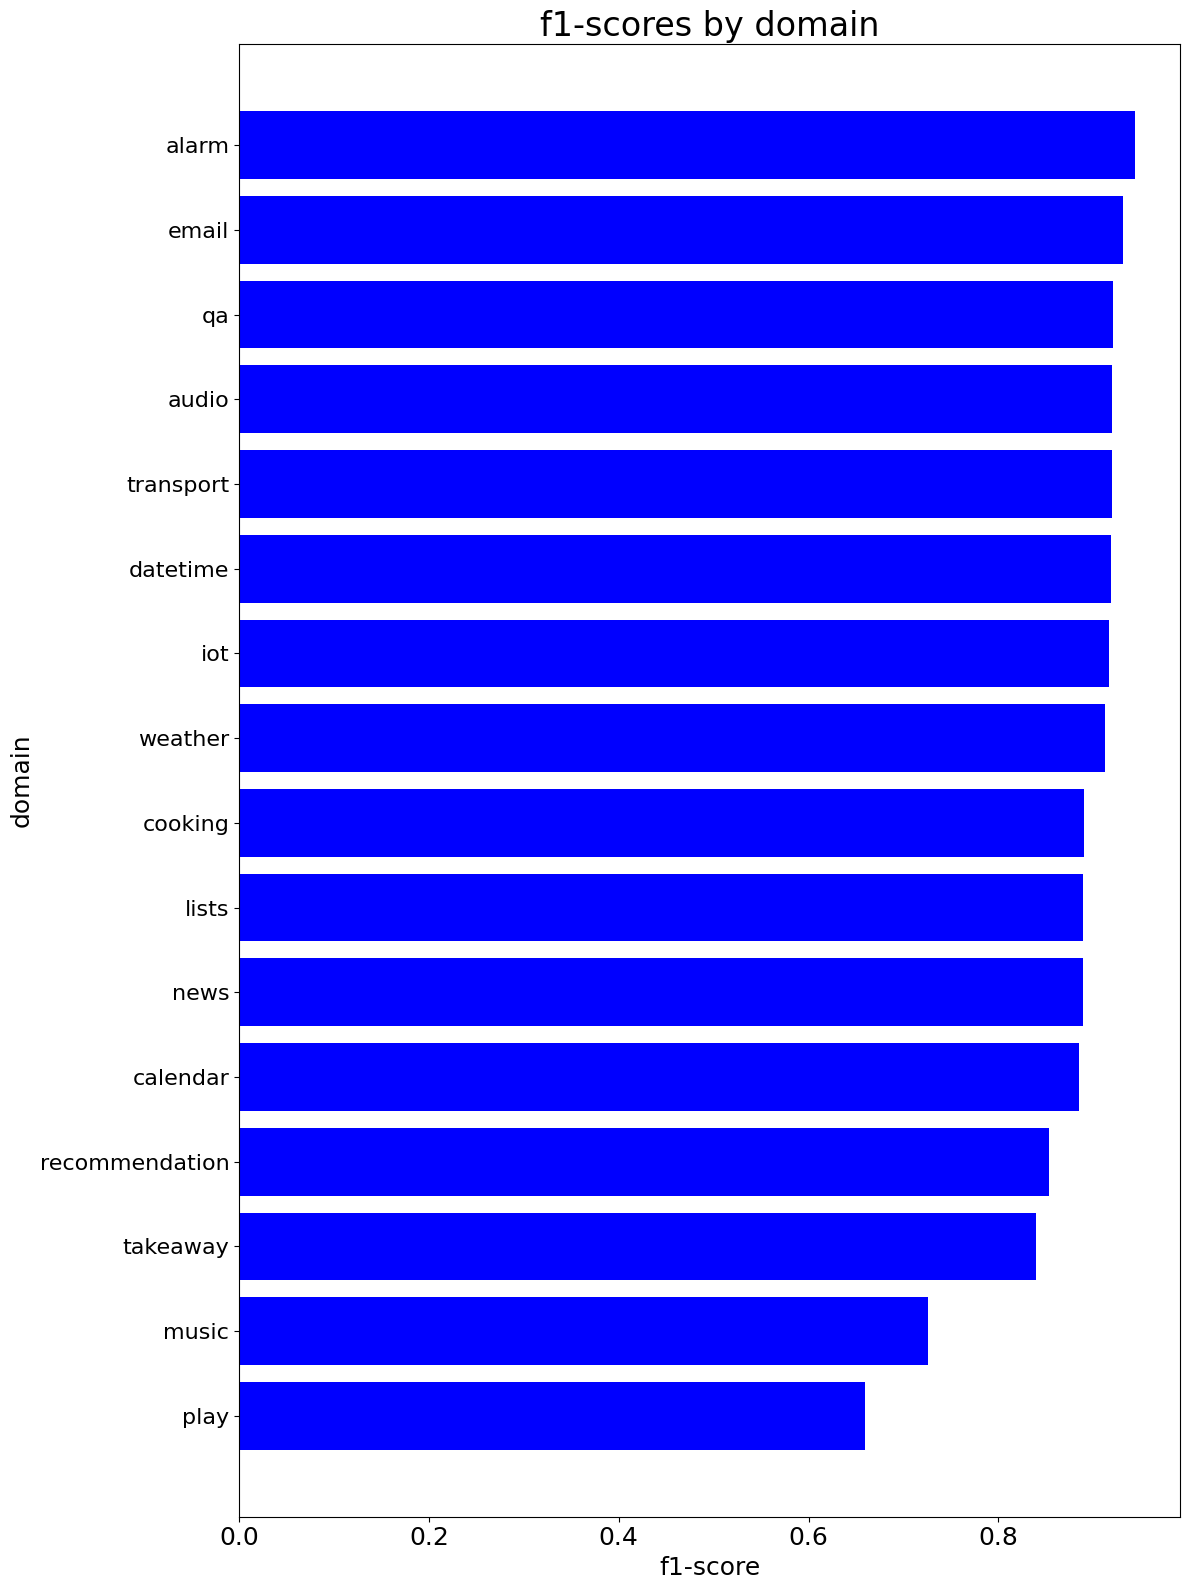

In [10]:
label = domain_entity_reports_df.columns[5]
Analytics.plot_entity_report(domain_entity_reports_df, label)

Save the report

In [ ]:
domain_entity_reports_df.to_csv('data/reports/domain_entity_reports.csv', index=False)

In [ ]:
#TODO: get, plot, and export domain entity reports
#TODO: rename notebook to macro_NLU_entity_general_reports.ipynb
#TODO: create new notebook for domain specific entity reports and entity refinement

Optional: we can train a classifier and save the model to disk. For the default intent refined dataset, we already saved a model we can load one cell below.

In [ ]:
crf_model = NLUEngine.train_entity_classifier(removed_nlu_data_refined_df)
model_path = 'models/analytics/entity_tagger.sav'
DataUtils.pickle_model(classifier=crf_model, model_path=model_path)

Let's load open up a model

In [ ]:
model_path = 'models/analytics/entity_tagger.sav'
crf_model = DataUtils.import_pickled_model(model_path)

With our model we can predict the tagging of the entities in the dataset. It might be a good idea to re-run this with a new model once and a while during refinement.

In [ ]:
nlu_data_df['predicted_tagging'] = nlu_data_df['answer_normalised'].apply(
    lambda x: NLUEngine.create_entity_tagged_utterance(x, crf_model))

removed_nlu_data_refined_df = nlu_data_df[nlu_data_df['remove'] != True]


In [ ]:
#TODO: save this nlu_data_df to a csv file

Let's have a look at the incorrect entities per domain.

In [ ]:
incorrect_tagged_df = removed_nlu_data_refined_df[removed_nlu_data_refined_df['answer_annotation']
                            != removed_nlu_data_refined_df['predicted_tagging']]


incorrect_tagged_domain_count_df = incorrect_tagged_df.groupby('scenario').size(
).reset_index(name='count').sort_values(by='count', ascending=False)


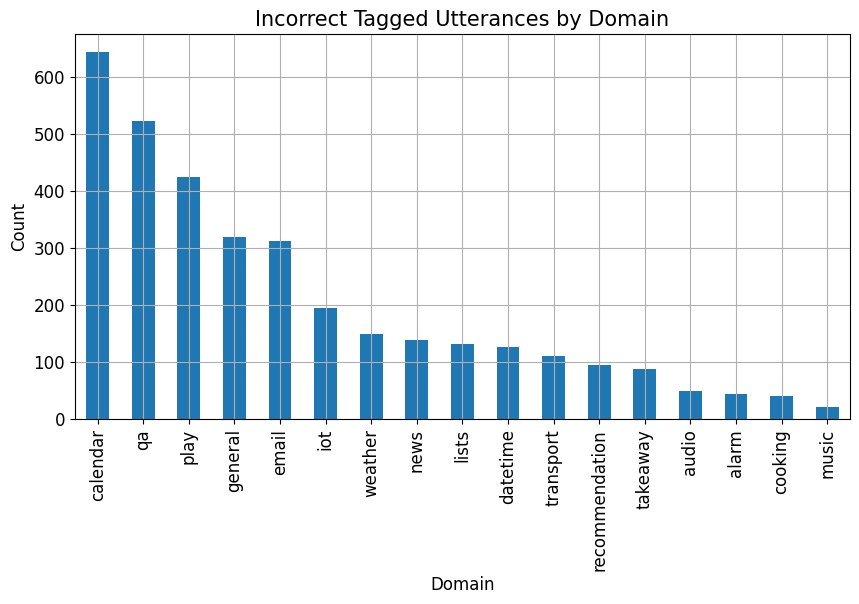

In [ ]:
#TODO: add this to analytics class
import matplotlib.pyplot as plt

incorrect_tagged_domain_count_df.plot(
    x='scenario', y='count', kind='bar', figsize=(10, 5), legend=False, grid=True, fontsize=12)
plt.xlabel('Domain', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Incorrect Tagged Utterances by Domain', fontsize=15)
plt.show()
